# VGGNet 16

- 2014 ILSVRC 2nd place
- VGG-16(D)
- Convolution layer
- Maxpooling layer
- Fully connected layer

![대체 텍스트](https://qph.fs.quoracdn.net/main-qimg-e657c195fc2696c7d5fc0b1e3682fde6)

In [ ]:
# 런타임 유형 GPU 모드로 변경
!pip install torch torchvision

### 1.학습전 세팅

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)

2.9.0+cu128


### 2.하이퍼 파라미터 설정

In [6]:
batch_size =1
learning_rate = 0.0002
num_epoch = 10

### 3.DataLoader

In [ ]:
# VGG16 입력 스펙 (224x224)기준
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224), # 랜덤하게 224x224 크기로 자릅니다.
    transforms.RandomHorizontalFlip(), # 랜덤하게 이미지를 좌우로 뒤집습니다.
    transforms.ToTensor() # 이미지를 텐서로 변환합니다.
])
# train_tf는 학습데이터이기에 Resize 대신 RandomResizedCrop을 사용하여 랜덤하게 자름.
# val_tf는 검증데이터이기에 Resize와 CenterCrop을 사용하여 일정하게 자름.

val_tf = transforms.Compose([
    transforms.Resize(256), # 이미지를 256x256 크기로 조정합니다.
    transforms.CenterCrop(224), # 중앙에서 224x224 크기로 자릅니다.
    transforms.ToTensor() # 이미지를 텐서로 변환합니다.
])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# ImageNet 데이터는 수동다운로드를 해야하므로 CIFAR100 데이터로 실습을 진행하겠습니다.
# CIFAR100 데이터는 32x32 크기의 컬러 이미지 입니다. 따라서 3x32x32 크기의 텐서로 표현됩니다.
# 또한 학습용 데이터는 5만개, 테스트용 데이터는 1만개로 이루어져 있습니다.
train_set = dset.CIFAR100(root="./data", train=True, transform=train_tf, download=True)
val_set   = dset.CIFAR100(root="./data", train=False, transform=val_tf, download=True)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)

### 4.VGG-16 모델구성

#### 4.1 Basic Block
- 모델에 반복되는 부분이 많기 때문에 이를 함수로 만들어 단순화 합니다.
- 맨 위에 이미지를 보면 컨볼루션 연산이 2번 연속하는 경우와 3번 연속하는 경우가 있는데 이를 각각 만들어줍니다.
- 아래의 코드는 최적의 방법이라기 보다는 그림의 구조를 모방한 코드입니다.

In [2]:
# VGG16 모델에서 2번 연속 사용되는 블록 정의입니다. (Conv2d - ReLU - Conv2d - ReLU - MaxPool2d)
class Conv2Block(nn.Module):
    def __init__(self, in_channel, out_channel): # 입력 채널 수와 출력 채널 수를 인자로 받습니다.
        super().__init__() # 부모 클래스의 초기화 함수를 호출합니다.
        self.block = nn.Sequential( # nn.Sequential을 사용하여 여러 레이어를 하나의 블록으로 묶습니다.
            
            nn.Conv2d(in_channel, out_channel, 3, 1, 1), # 3x3 필터, 스트라이드 1, 패딩 1인 2D 합성곱 레이어입니다.
            nn.ReLU(inplace=True), # 활성화 함수로 ReLU를 사용합니다. inplace=True는 입력 텐서를 직접 수정하여 메모리를 절약합니다.

            nn.Conv2d(out_channel, out_channel, 3, 1, 1), # 3x3 필터, 스트라이드 1, 패딩 1인 2D 합성곱 레이어입니다.
            nn.ReLU(inplace=True), # 활성화 함수로 ReLU를 사용합니다. inplace=True는 입력 텐서를 직접 수정하여 메모리를 절약합니다.

            nn.MaxPool2d(2,2), # 2x2 필터, 스트라이드 2인 2D 최대 풀링 레이어입니다. 입력 크기를 절반으로 줄입니다.
        )
    def forward(self, x): # 순전파 함수를 정의합니다. 입력 x를 블록에 통과시켜 출력합니다.
        return self.block(x)

In [3]:
# VGG16 모델에서 3번 연속 사용되는 블록 정의입니다. (Conv2d - ReLU - Conv2d - ReLU - Conv2d - ReLU - MaxPool2d)
class Conv3Block(nn.Module):
    def __init__(self, in_channel, out_channel): # 입력 채널 수와 출력 채널 수를 인자로 받습니다.
        super().__init__() # 부모 클래스의 초기화 함수를 호출합니다.
        self.block = nn.Sequential( # nn.Sequential을 사용하여 여러 레이어를 하나의 블록으로 묶습니다.
            
            nn.Conv2d(in_channel, out_channel, 3, 1, 1), # 3x3 필터, 스트라이드 1, 패딩 1인 2D 합성곱 레이어입니다.
            nn.ReLU(inplace=True), # 활성화 함수로 ReLU를 사용합니다. inplace=True는 입력 텐서를 직접 수정하여 메모리를 절약합니다.

            nn.Conv2d(out_channel, out_channel, 3, 1, 1), # 3x3 필터, 스트라이드 1, 패딩 1인 2D 합성곱 레이어입니다.
            nn.ReLU(inplace=True), # 활성화 함수로 ReLU를 사용합니다. inplace=True는 입력 텐서를 직접 수정하여 메모리를 절약합니다.

            nn.Conv2d(out_channel, out_channel, 3, 1, 1), # 3x3 필터, 스트라이드 1, 패딩 1인 2D 합성곱 레이어입니다.
            nn.ReLU(inplace=True), # 활성화 함수로 ReLU를 사용합니다. inplace=True는 입력 텐서를 직접 수정하여 메모리를 절약합니다.

            nn.MaxPool2d(2,2), # 2x2 필터, 스트라이드 2인 2D 최대 풀링 레이어입니다. 입력 크기를 절반으로 줄입니다.
        )
    def forward(self, x): # 순전파 함수를 정의합니다. 입력 x를 블록에 통과시켜 출력합니다.
        return self.block(x)

#### 4.2 VGG16 모델

In [4]:
# VGG16 [2, 2, 3, 3, 3]구조
class VGG16(nn.Module):
    def __init__(self, num_classes=100): # 클래스 수를 인자로 받습니다. CIFAR100 데이터셋은 100개의 클래스를 가지고 있습니다.
        super().__init__() # 부모 클래스의 초기화 함수를 호출합니다.
        self.layers = nn.Sequential( # nn.Sequential을 사용하여 여러 레이어를 하나의 블록으로 묶습니다. 
            Conv2Block(3, 64), # 첫 번째 블록은 입력 채널 3, 출력 채널 64입니다. 224x224 -> 112x112
            Conv2Block(64, 128), # 두 번째 블록은 입력 채널 64, 출력 채널 128입니다. 112x112 -> 56x56

            Conv3Block(128, 256), # 세 번째 블록은 입력 채널 128, 출력 채널 256입니다. 56x56 -> 28x28
            Conv3Block(256, 512), # 네 번째 블록은 입력채널 256, 출력채널 512입니다. 28x28 -> 14x14
            Conv3Block(512, 512), # 다섯 번째 블록은 입력채널 512, 출력채널 512입니다. 14x14 -> 7x7
        )
        # (N, 512, 7, 7) -> (N, 25088) -> (N, 4096) -> (N, 4096) -> (N, num_classes)
        self.fcs = nn.Sequential( # nn.Sequential을 사용하여 여러 FC 레이어를 하나의 블록으로 묶습니다.
            nn.Flatten(), # 입력 텐서를 1차원으로 펼칩니다. 512x7x7 -> 25088
            nn.Linear(512*7*7, 4096), # 첫 번째 FC 레이어는 입력 크기 25088, 출력 크기 4096입니다.
            nn.ReLU(inplace=True),
            nn.Dropout(0.5), # 드롭아웃 레이어는 과적합을 방지하기 위해 뉴런을 비활성화 합니다.
            nn.Linear(4096, 4096), # 4096 -> 4096
            nn.ReLU(inplace=True),
            nn.Dropout(0.5), # 드롭아웃 레이어는 과적합을 방지하기 위해 뉴런을 비활성화 합니다.
            nn.Linear(4096, num_classes), # 4096 -> 클래스 수 100
        )
    def forward(self, x): # 순전파 함수를 정의합니다. 입력 x를 레이어에 통과시켜 출력합니다.
        x = self.layers(x) # 입력 x를 레이어 블록에 통과시킵니다.
        x = self.fcs(x) # 레이어 블록의 출력을 FC 블록에 통과시킵니다.
        return x # 최종 출력값을 반환합니다.

### 5.손실함수, 최적화 정의

In [7]:
# gpu 사용이 가능하면 gpu로 모델과 손실함수, 최적화 함수를 옮겨줍니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16(num_classes=100).to(device)

# 손실함수 정의 
loss_fn = nn.CrossEntropyLoss()

# 최적화 함수 정의
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# 모델 구조 출력
for i in model.named_children():
    print(i)

('layers', Sequential(
  (0): Conv2Block(
    (block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (1): Conv2Block(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (2): Conv3Block(
    (block): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
     

In [11]:
!pip install torchinfo
!pip install torchview

In [12]:
from torchinfo import summary
summary(model, input_size=(1, 3, 224, 224))  # (batch, C, H, W)


Layer (type:depth-idx)                   Output Shape              Param #
VGG16                                    [1, 100]                  --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2Block: 2-1                   [1, 64, 112, 112]         --
│    │    └─Sequential: 3-1              [1, 64, 112, 112]         38,720
│    └─Conv2Block: 2-2                   [1, 128, 56, 56]          --
│    │    └─Sequential: 3-2              [1, 128, 56, 56]          221,440
│    └─Conv3Block: 2-3                   [1, 256, 28, 28]          --
│    │    └─Sequential: 3-3              [1, 256, 28, 28]          1,475,328
│    └─Conv3Block: 2-4                   [1, 512, 14, 14]          --
│    │    └─Sequential: 3-4              [1, 512, 14, 14]          5,899,776
│    └─Conv3Block: 2-5                   [1, 512, 7, 7]            --
│    │    └─Sequential: 3-5              [1, 512, 7, 7]            7,079,424
├─Sequential: 1-2                        [1, 100]      

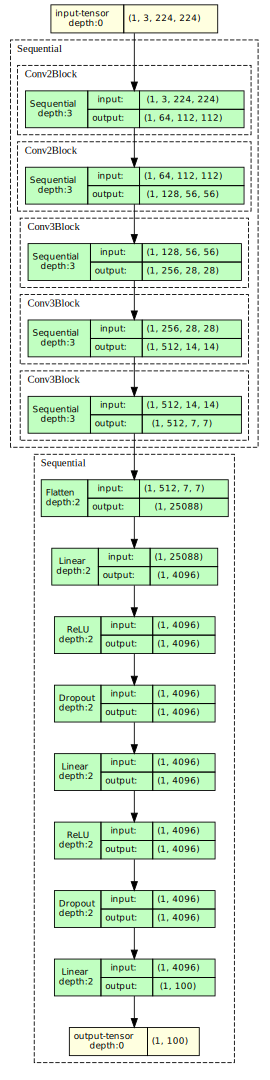

In [13]:
from torchview import draw_graph
g = draw_graph(model, input_size=(1, 3, 224, 224), expand_nested=True)
g.visual_graph 

### 6. Train

In [ ]:
# Train
for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0

    for step, (image, label) in enumerate(train_loader):
        x = image.to(device)
        y = label.to(device)

        optimizer.zero_grad() # 모델의 가중치 업데이트 전에 기울기를 초기화합니다. 그렇지 않으면 이전 배치에서 계산된 기울기가 누적됩니다.
        output = model(x)     # 모델에 입력 x를 넣어서 예측값 output을 계산합니다.
        loss = loss_fn(output, y) # 모델의 예측값 output과 실제 정답 y_를 이용하여 손실함수 값을 계산합니다.
        loss.backward() # 손실함수 값을 모델의 가중치에 대한 기울기로 바꿔줍니다. 이 과정에서 역전파 알고리즘이 사용됩니다.
        optimizer.step() # 모델의 가중치를 기울기에 따라 업데이트합니다. 이 과정에서 최적화 알고리즘이 사용됩니다.

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"[Epoch {epoch+1}/{num_epoch}] train_loss: {epoch_loss:.4f}")


In [ ]:
# Validation
model.eval() # 모델을 평가 모드로 설정합니다. 이 모드에서는 드롭아웃과 배치 정규화 레이어가 비활성화됩니다.
val_loss = 0.0 # 검증 손실을 저장할 변수를 초기화합니다.
correct = 0 # 모델의 예측이 실제 정답과 일치하는 경우의 수를 저장할 변수를 초기화합니다.
total = 0 # 모델이 예측한 총 샘플 수를 저장할 변수를 초기화합니다.

with torch.no_grad():
    for image, label in val_loader:
        x = image.to(device)
        y = label.to(device)

        output = model(x)
        loss = loss_fn(output, y)

        val_loss += loss.item() # 검증 손실을 누적합니다.
        pred = output.argmax(dim=1) # 모델의 예측값 output에서 가장 높은 확률을 가진 클래스의 인덱스를 pred에 저장합니다.
        correct += (pred == y).sum().item() # 모델의 예측값 pred와 실제 정답 y가 일치하는 경우의 수를 correct에 누적합니다.
        total += y.size(0)

val_loss /= len(val_loader)
val_acc = 100.0 * correct / total
print(f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.2f}%")
